In [2]:
%pip install qiskit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.9/929.9 KB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 

In [22]:
import numpy as np
from qiskit.visualization import plot_histogram
import time

In [8]:
n=2
lis=[2,3,1,0]
missingno=lis[0]
lis.remove(missingno)


In [5]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit.result.counts import Counts
from typing import Tuple

In [25]:
def diffuser(n_qubits: int) -> Gate:      
    

    qc = QuantumCircuit(n_qubits)

    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(range(n_qubits))

    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(range(n_qubits))

    # Do multi-controlled-Z gate
    qc.h(n_qubits-1)
    
    qc.mct(list(range(n_qubits-1)), n_qubits-1)  # multi-controlled-toffoli

    qc.h(n_qubits-1)

    # Apply transformation |11..1> -> |00..0>
    qc.x(range(n_qubits))

    # Apply transformation |00..0> -> |s>
    qc.h(range(n_qubits))

    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "D$_s$"

    return U_s

def get_grovers_oracle(input_vector, n_qubits) -> Gate:
    """
    It takes in a list of numbers and returns a unitary matrix that flips the sign of the corresponding
    basis states i.e. Grover's oracle.
    
    Args:
      input_vector: the vector we want to find the index of
      n_qubits: the number of qubits in the circuit
    
    Returns:
      A unitary matrix
    """
    
    U = -1*np.eye(2**n_qubits)
    
    # Flip the sign of the basis states corresponding to the input vector
    for num in input_vector:
        U[num][num] = 1

    qc = QuantumCircuit(n_qubits)
    qc.unitary(U, range(n_qubits))

    # Return the oracle as a gate
    oracle = qc.to_gate()
    oracle.name = "U$_f$"

    return oracle

def missing_number(input_vector) :
   

    l = len(input_vector)

    # Check if l+1 is power of 2
    if ((l+1) & (l)) != 0:
        raise ValueError("The length of the input vector must be one less than a power of 2.")

    n_qubits = int(np.ceil(np.log2(l+1)))

    oracle = get_grovers_oracle(input_vector, n_qubits)
    
    # Initialize the circuit
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    
    # Apply Grover's algorithm
    num_iterations = int((np.pi/4)*np.sqrt(2**n_qubits))

    for _ in range(num_iterations):
        qc.append(oracle, range(n_qubits))
        qc.append(diffuser(n_qubits), range(n_qubits))
    
    # Measure the circuit
    qc.measure_all()
    
    # Run the circuit
    aer_sim = Aer.get_backend('aer_simulator') 
    t_qc = transpile(qc, aer_sim) # Transpilation
    qobj = assemble(t_qc) 

    # Get the results
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()

    # find the key of the maximum value
    max_key = max(counts, key=counts.get)
    
    # Convert the binary string to decimal
    missing_num = int(max_key, 2)
   
    return missing_num,counts

In [29]:
t=missing_number(lis)
counts=t[1]
print(counts)
print(t[0])

{'10': 1024}
2


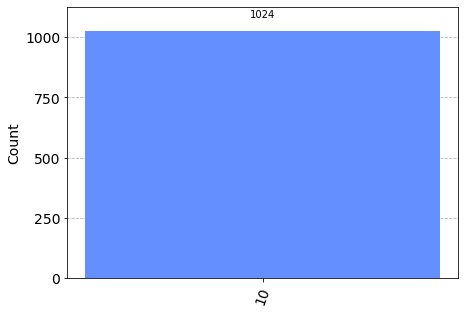

In [28]:
plot_histogram(counts)